# Multimodal Agent Chat for Content Generation: DALL-E 3 and GPT-4o

<img src="media/autogen-interior-design.png" alt="Image description" width="700">

This notebook uses the following agents:

1. __User proxy__: Represents the human user who provides an initial text prompt for image generation
2. __Image creator__: DALL-E 3 image generation based on the provided text prompt
3. __Critic__: Provides detailled critic about the generated image and a revised text prompt in order to improve the image

## Setup
Install pyautogen with llm option:
```bash
pip install "pyautogen[lmm]>=0.2.3"
```

In [9]:
import os
import re
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
from dotenv import load_dotenv, find_dotenv

from IPython.display import display
from PIL import Image

import PIL
from diskcache import Cache
from openai import OpenAI, AzureOpenAI
from PIL import Image

from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data, get_pil_image
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

In [10]:
load_dotenv(find_dotenv())
aoai_endpoint_useast = os.getenv("AOAI_ENDPOINT_USEAST")
aoai_key_useast = os.getenv("AOAI_KEY_USEAST")

config_list_gpt4 = [
    {'model' : 'gpt-4o-global',
     'azure_endpoint' : aoai_endpoint_useast,
     'api_key': aoai_key_useast,
     'api_type' : 'azure',
     'api_version' : '2024-05-01-preview'}
]

config_list_dalle = [
    {'model' : 'dalle',
     'azure_endpoint' : aoai_endpoint_useast,
     'api_key': aoai_key_useast,
     'api_type' : 'azure',
     'api_version' : '2024-05-01-preview'}
]

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": None}

## Helper Functions

In [11]:
def dalle_call(client: AzureOpenAI, model: str, prompt: str, size: str, quality: str, n: int, use_cache: bool = False) -> str:
    """
    Generate an image using OpenAI's DALL-E model and cache the result.

    This function takes a prompt and other parameters to generate an image using OpenAI's DALL-E model.
    It checks if the result is already cached; if so, it returns the cached image data. Otherwise,
    it calls the DALL-E API to generate the image, stores the result in the cache, and then returns it.

    Args:
        client (OpenAI): The OpenAI client instance for making API calls.
        model (str): The specific DALL-E model to use for image generation.
        prompt (str): The text prompt based on which the image is generated.
        size (str): The size specification of the image.
        quality (str): The quality setting for the image generation.
        n (int): The number of images to generate.
        use_cache (bool) : Select if cache should be used

    Returns:
    str: The image data as a string, either retrieved from the cache or newly generated.

    Note:
    - The cache is stored in a directory named '.cache/'.
    - The function uses a tuple of (model, prompt, size, quality, n) as the key for caching.
    - The image data is obtained by making a secondary request to the URL provided by the DALL-E API response.
    """
    if use_cache:
        cache = Cache(".cache/")  # Create a cache directory
        key = (model, prompt, size, quality, n)
        if key in cache:
            return cache[key]

    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    if use_cache:
        cache[key] = img_data

    return img_data


def extract_img(agent: Agent) -> PIL.Image:
    """
    Extracts an image from the last message of an agent and converts it to a PIL image.

    This function searches the last message sent by the given agent for an image tag,
    extracts the image data, and then converts this data into a PIL (Python Imaging Library) image object.

    Parameters:
        agent (Agent): An instance of an agent from which the last message will be retrieved.

    Returns:
        PIL.Image: A PIL image object created from the extracted image data.

    Note:
    - The function assumes that the last message contains an <img> tag with image data.
    - The image data is extracted using a regular expression that searches for <img> tags.
    - It's important that the agent's last message contains properly formatted image data for successful extraction.
    - The `_to_pil` function is used to convert the extracted image data into a PIL image.
    - If no <img> tag is found, or if the image data is not correctly formatted, the function may raise an error.
    """
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        assert isinstance(last_message[0], dict)
        img_data = last_message[0]["image_url"]["url"]

    pil_img = get_pil_image(img_data)
    return pil_img


def extract_prompt_content(feedback: str) -> str:
    """ Extract image generation prompt from critics feedback message """
    prompt_marker = "PROMPT:"
    try:
        start_index = feedback.index(prompt_marker) + len(prompt_marker)
        # Find the start of the content, skipping any whitespace
        while start_index < len(feedback) and feedback[start_index].isspace():
            start_index += 1
        return feedback[start_index:]
    except ValueError:
        return ""
    
def display_image(pil_image, width=800):
    """
    Display a PIL image in a Jupyter notebook with the specified width while maintaining aspect ratio.

    :param pil_image: PIL image object.
    :param width: Desired width of the displayed image.
    """
    # Calculate the new height to maintain aspect ratio
    aspect_ratio = pil_image.height / pil_image.width
    height = int(width * aspect_ratio)
    
    # Resize the image
    resized_image = pil_image.resize((width, height), Image.LANCZOS)
    
    # Display the image
    display(resized_image)


## The DALL-E 3 Agent
Custom agent based on ConversableAgent to generate images using the DALL-E 3 API 

In [12]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)
        
        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
            api_version = config_list[0]["api_version"]
            azure_endpoint = config_list[0]["azure_endpoint"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")

        self._dalle_client = AzureOpenAI(api_version=api_version, api_key=api_key, azure_endpoint=azure_endpoint)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(self, message: Union[Dict, str], recipient: Agent, request_reply: Optional[bool] = None, silent: Optional[bool] = False):
        # override and always "silent" the send out message to avoid extreme long printed outputs
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config):
        """Generate a reply using OpenAI DALLE call."""
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1792x1024",
            quality="hd",
            n=1,
        )

        img_data = _to_pil(img_data)

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

## Call the Image Creator from the User Proxy

In [13]:
# dalle = DALLEAgent(name="Dalle", llm_config={"config_list": config_list_dalle})

# user_proxy = UserProxyAgent(
#     name="User_proxy", system_message="A human admin.", human_input_mode="NEVER", max_consecutive_auto_reply=0
# )

# user_proxy.initiate_chat(
#     dalle,
#     message="Woman face with centered explosion of colorful powder on a black background.",
# )

# img = extract_img(dalle)
# display_image(img)

## Iterate several times with Critics

In [14]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a DalleCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among
        its child agents: dalle and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]

        # Define the agents
        self.critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""You are an image generation prompt engineering expert who improves the prompt of the image you saw to generate a new image using the DALL-E 3 image generation model.
            Consider the following:
            - How to create an image that better matches the prompt
            - Improve the image in terms of composition, color, shape, quality etc.
            - If the initial prompt asks for a text to be displayed, check if represented in the image without mistakes.
            Keep in mind that the image generation model might not be able to consider all details. Focus on the most important aspects in the revised prompt.

            Reply in  the following format:
            CRITICS: 
            <numbered list of critics>
            PROMPT:
            <your revised text prompt as input for the DALL-E 3 image generation model>
            """,
            llm_config={"config_list": config_list_gpt4, "max_tokens": 1000},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.dalle = DALLEAgent(
            name="Dalle", llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0
        )

        # Data flow begins
        self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
        img = extract_img(self.dalle)

        display_image(img)
        print("Image PLOTTED")

        for i in range(self._n_iters):
            img = extract_img(self.dalle)
            img.save("result.png")

            self.msg_to_critics = f"""Here is the prompt: {img_prompt}.
            Here is the image <img result.png>.
            Now, provide your critic and create a prompt optimized for the DALL-E 3 image generation model so it can generate a better image.
            Show both "CRITICS" and "PROMPT".
            """
            self.send(message=self.msg_to_critics, recipient=self.critics, request_reply=True)
            feedback = self._oai_messages[self.critics][-1]["content"]
            
            img_prompt = extract_prompt_content(feedback)

            self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
            img = extract_img(self.dalle)
            display_image(img)
            print(f"Image {i} PLOTTED")

        return True, "result.jpg"

In [ ]:
creator = DalleCreator(
    name="DALL-E 3 Creator",
    max_consecutive_auto_reply=0,
    system_message="Help me to coordinate generating an image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""Ad for a cat food with russian blue cat"""
)

In [18]:
import sys
sys.exit('Stop execution here')

SystemExit: Stop execution here

/home/akopp/miniconda3/envs/autogen/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


User (to DALL-E 3 Creator):

Modern living room with lake view

--------------------------------------------------------------------------------


DALL-E 3 Creator (to Dalle):

Modern living room with lake view

--------------------------------------------------------------------------------


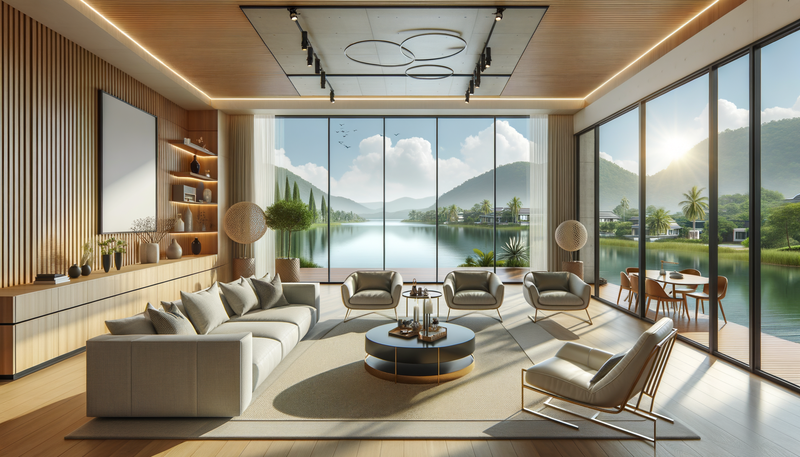

Image PLOTTED
DALL-E 3 Creator (to Critics):

Here is the prompt: Modern living room with lake view.
            Here is the image <image>.
            Now, provide your critic and create a prompt optimized for DALL-E 3 so that DALLE can generate better image.
            Show both "CRITICS" and "PROMPT".
            

--------------------------------------------------------------------------------
Critics (to DALL-E 3 Creator):

CRITICS:
1. The image already captures a great modern living room with a beautiful lake view, but there are always small improvements that can be made.
2. The color scheme is cohesive and modern, but it might benefit from a slight pop of color for more visual interest.
3. The space could potentially incorporate more personal touches or contemporary art pieces to enhance the overall modern feel.
4. The view is stunning, but adding a small boat or people by the lake could make it more dynamic and lively.
5. The furnishings and layout are excellent, yet the addit

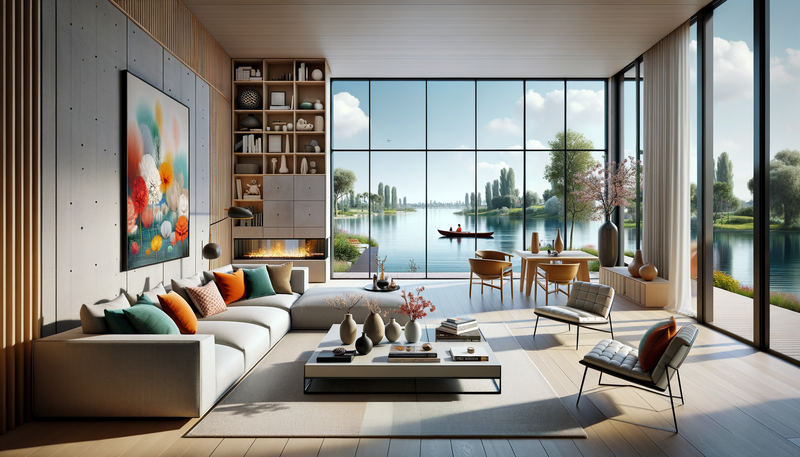

Image 0 PLOTTED
DALL-E 3 Creator (to Critics):

Here is the prompt: A modern living room with a stunning lake view through floor-to-ceiling windows. The room features a neutral color palette with a pop of vibrant color through accent pillows and artwork. Contemporary furniture includes a sophisticated sectional sofa, designer chairs, and a sleek coffee table. Add personal touches such as stylish vases, modern art pieces, and books on built-in shelves. The view outside shows a serene lake with a small boat and a few people by the shore, capturing a lively and dynamic scene. Optionally, include a modern fireplace to enhance the cozy atmosphere of the space..
            Here is the image <image>.
            Now, provide your critic and create a prompt optimized for DALL-E 3 so that DALLE can generate better image.
            Show both "CRITICS" and "PROMPT".
            

--------------------------------------------------------------------------------
Critics (to DALL-E 3 Creator):

CR

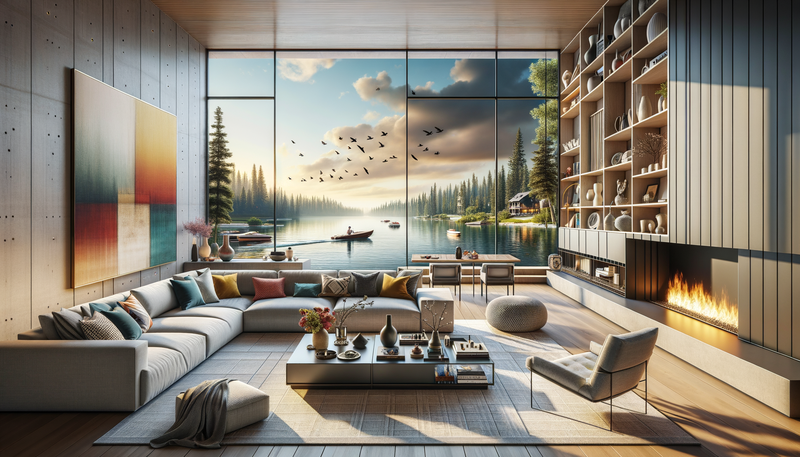

Image 1 PLOTTED
DALL-E 3 Creator (to User):

result.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Modern living room with lake view', 'role': 'assistant'}, {'content': 'result.jpg', 'role': 'user'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [ ]:
creator = DalleCreator(
    name="DALL-E 3 Creator",
    max_consecutive_auto_reply=0,
    system_message="Help me to coordinate generating an image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""Modern living room with lake view"""
)